
LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x15d9fe970>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x32eae5700>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <__main__.LearnedQuantizedDense object at 0x32e30c400>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)
  - Shape of scale_w: (784, 1)
  - Shape of scale_b: (128,)

LAYER 3: <__main__.LearnedQuantizedDense object at 0x15ac62c40>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
  - Shape of scale_w: (128, 1)
  - Shape of scale_b: (10,)
Epoch 1/20
TESTING (784,) (784, 1)
TESTING (128,) (128, 1)
TESTING (784,) (784, 1)
TESTING (128,) (128, 1)
1875/1875 [==============================] - ETA: 0s - loss: 4.3436 - accuracy: 0.7814TESTING (784,) (784, 1)
TESTING (128,) (128, 1)

Epoch 1: 
Average scale value of w: 0.012105103582143784, 
Average scale value of b: -0.0054298164322

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_6970/171102445.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


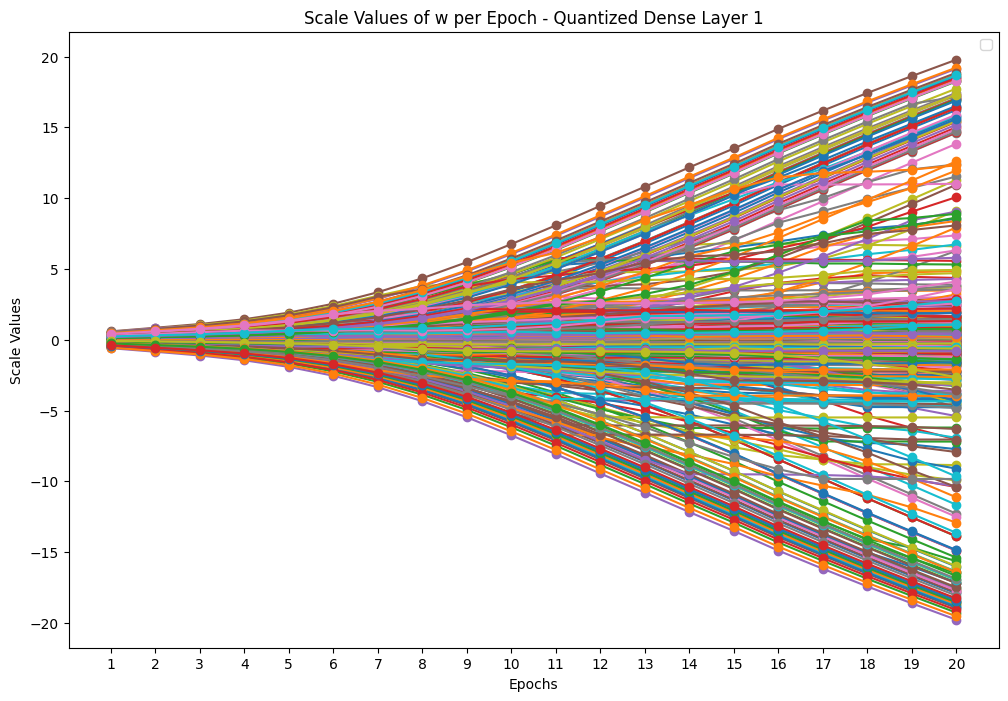

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_6970/171102445.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


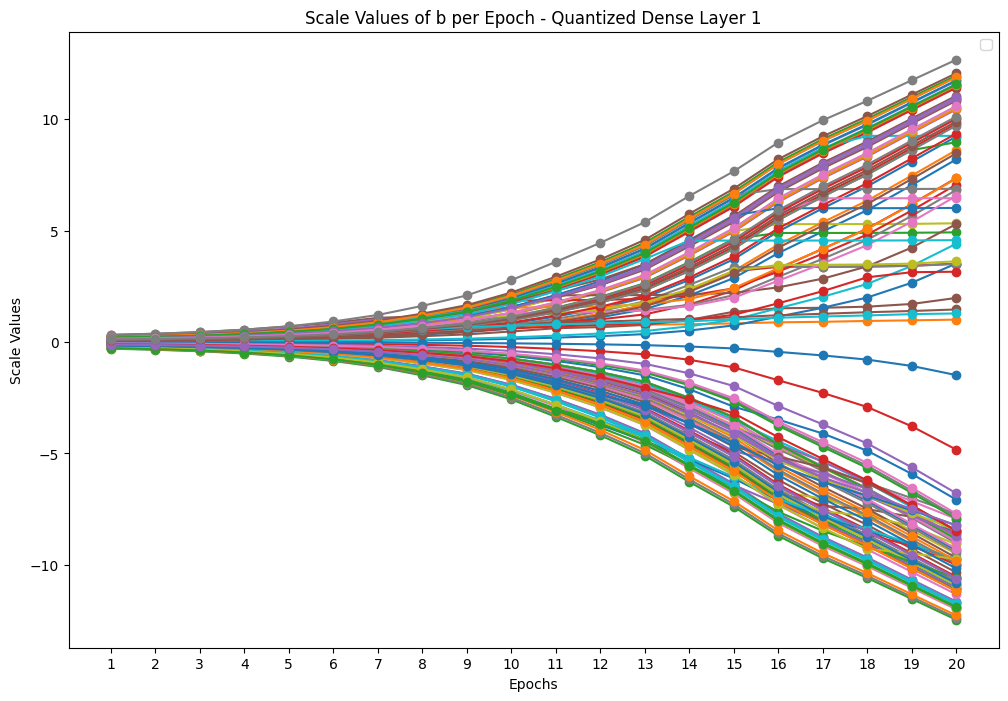

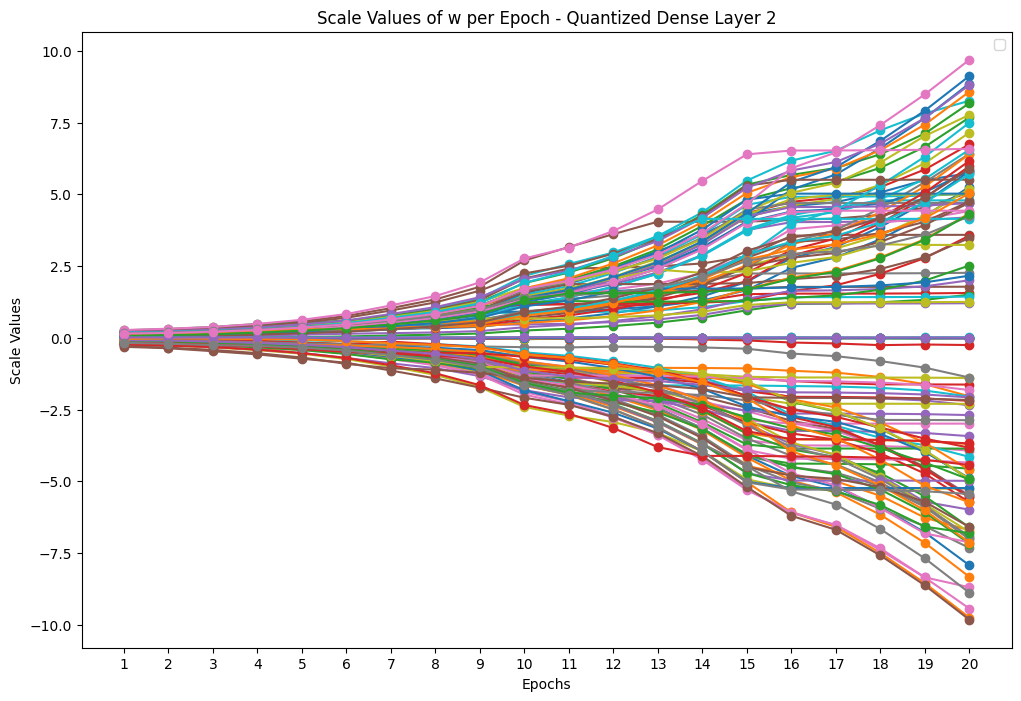

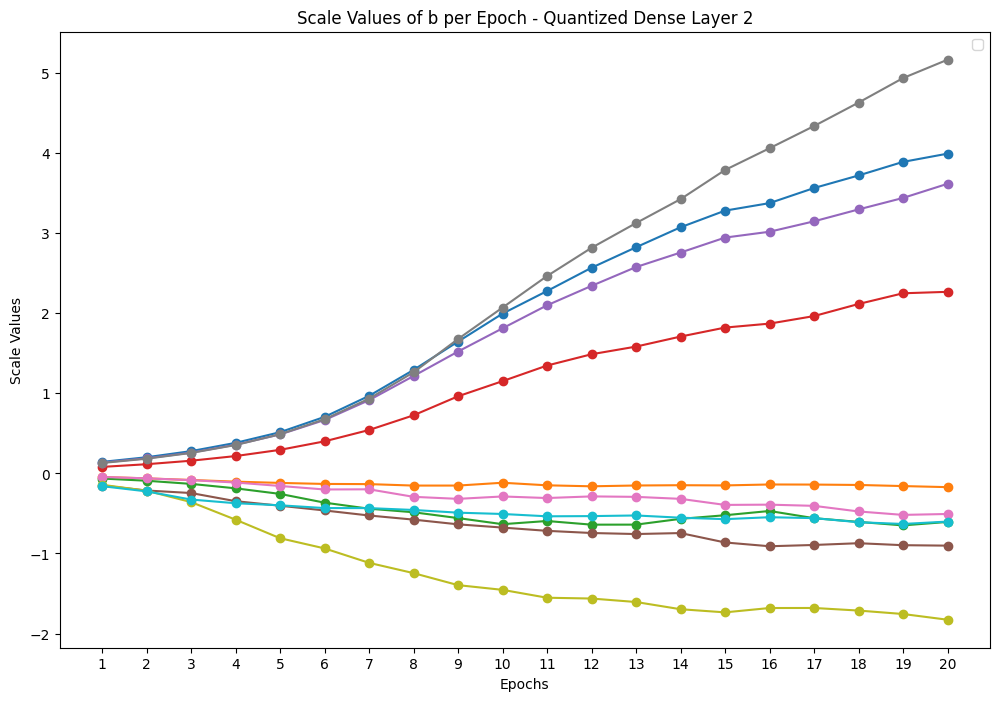

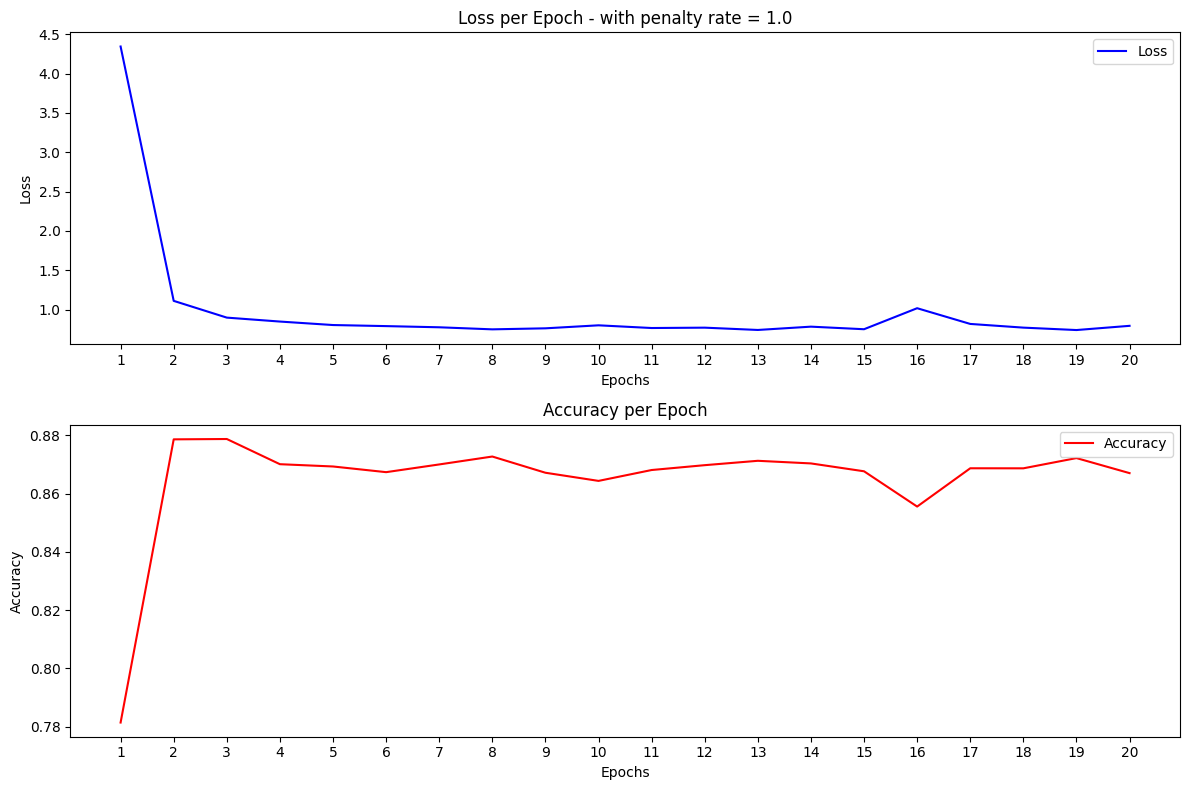

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


eps_float32 = np.finfo(np.float32).eps

class ScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(ScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch_w = []
        self.average_scale_values_w = []
        self.scale_values_per_epoch_b = []
        self.average_scale_values_b = []

        self.epoch_loss = []
        self.epoch_accuracy = []
        self.num_epochs = 0

    def on_epoch_end(self, epoch, logs=None):
        scale_values_w = self.layer.scale_w.numpy().flatten()
        self.scale_values_per_epoch_w.append(scale_values_w)
        average_scale_value_w = np.mean(scale_values_w)
        self.average_scale_values_w.append(average_scale_value_w)

        scale_values_b = self.layer.scale_b.numpy().flatten()
        self.scale_values_per_epoch_b.append(scale_values_b)
        average_scale_value_b = np.mean(scale_values_b)
        self.average_scale_values_b.append(average_scale_value_b)

        self.epoch_loss.append(logs['loss'])
        self.epoch_accuracy.append(logs['accuracy'])
        print(f"\nEpoch {epoch+1}: \nAverage scale value of w: {average_scale_value_w}, \nAverage scale value of b: {average_scale_value_b}, \nLoss: {logs['loss']}, \nAccuracy: {logs['accuracy']}")

        # Save losses to file
        with open("loss_data.txt", 'a') as f:
            f.write(f"Epoch {epoch+1}, Total Loss: {logs['loss']}\n")


    def plot_scale_values(self, layer_name):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch_w[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch_w]
            plt.plot(range(1, len(self.scale_values_per_epoch_w) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values of w per Epoch - ' + layer_name)
        plt.xticks(range(1, len(self.average_scale_values_w) + 1))  
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch_b[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch_b]
            plt.plot(range(1, len(self.scale_values_per_epoch_b) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values of b per Epoch - ' + layer_name)
        plt.xticks(range(1, len(self.average_scale_values_b) + 1))  
        plt.legend()
        plt.show()

    def plot_loss_accuracy(self, penalty_rate):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch - with penalty rate = ' + penalty_rate)
        plt.xticks(range(1, len(self.average_scale_values_w) + 1))  
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.epoch_accuracy) + 1))  
        plt.legend()

        plt.tight_layout()
        plt.show()

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
        self.scale_w = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.scale_b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)


    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.floor(self.w / self.scale_w)) + self.w / self.scale_w - tf.stop_gradient(self.w / self.scale_w)
        #quantized_w = tf.stop_gradient(tf.floor(self.w / self.scale_w))

        dequantized_w = quantized_w * self.scale_w

        quantized_b = tf.stop_gradient(tf.floor(self.b / self.scale_b)) + (self.b / self.scale_b - tf.stop_gradient(self.b / self.scale_b))
        #quantized_b = tf.stop_gradient(tf.floor(self.b / self.scale_b))

        dequantized_b = quantized_b * self.scale_b

        output = tf.matmul(inputs, dequantized_w) + dequantized_b
#        output = tf.matmul(inputs, quantized_w) + quantized_b

        # How is the gradient actually getting pushed through? 
        # Right now the gradients are being calculated by the quantized values because that is what we're putting to the tf.matmul
        # Therefore the the gradients of quantized values are the ones get pushed further, back through the subsequent layers as if it was quantized, b
        # but also pushed through that part that you don't have the stop gradient on, right? I do not see why you could not get the gradients in a different way.
        # Right now, I would use the second version and try to make that work. The thing is that you can get the gradients in your loss function, 
        # but how you would do that is that you do it exactly what it says. self.w/self.scale_w ->
        # Instead of returning outputs, you return 
        # the plus minus thing gets expensive
        # If you return the self.w/self.scale_w as a secondary output, then you can use that term that comes out in the loss. 
        # If you go to your loss function
        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_scale(self):
        return self.scale_w, self.scale_b

def custom_loss(y_true, y_pred, scales_of_layers, weights_and_biases, penalty_rate):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    # small epsilon to avoid division by zero
    epsilon = eps_float32
    scale_penalty = 0
    
    for i, ((scale_w, scale_b), (w, b)) in enumerate(zip(scales_of_layers, weights_and_biases)):
        max_w = tf.reduce_max(w, axis=1)
        print("TESTING", max_w.shape, scale_w.shape)
        min_w = tf.reduce_min(w, axis=1)
        max_b = tf.reduce_max(b)
        min_b = tf.reduce_min(b)
        
        max_w_quantized = (max_w / (scale_w + epsilon))
        min_w_quantized = (min_w / (scale_w + epsilon))
        max_b_quantized = (max_b / (scale_b + epsilon))
        min_b_quantized = (min_b / (scale_b + epsilon))

        range_of_quant_w = max_w_quantized - min_w_quantized
        range_of_quant_b = max_b_quantized - min_b_quantized

        scale_penalty += tf.reduce_mean(tf.abs(range_of_quant_w))
        scale_penalty += tf.reduce_mean(tf.abs(range_of_quant_b))
    
    total_loss = cross_entropy_loss + penalty_rate * scale_penalty
    
    return total_loss

input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
flatten_layer = tf.keras.layers.Flatten()(input_layer)
quantized_dense_layer1 = LearnedQuantizedDense(128, activation='relu')
dense_output1 = quantized_dense_layer1(flatten_layer)
quantized_dense_layer2 = LearnedQuantizedDense(10, activation='softmax')
output_layer = quantized_dense_layer2(dense_output1)

quantized_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Print layer details
for i, layer in enumerate(quantized_model.layers):
    print(f"\nLAYER {i}: {layer}")
    print(f"  - Input Shape: {layer.input_shape}")
    print(f"  - Output Shape: {layer.output_shape}")
    if hasattr(layer, 'get_scale'):
        print(f"  - Shape of scale_w: {layer.get_scale()[0].shape}")
        print(f"  - Shape of scale_b: {layer.get_scale()[1].shape}")



penalty_rates = [#0.0, 
                 #0.1, 
                 1.0, 
                 #10.0
                 ]

for penalty_rate in penalty_rates:
    quantized_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 
                                                [quantized_model.get_layer(index=2).get_scale(), 
                                                quantized_model.get_layer(index=3).get_scale()],
                                                [(quantized_model.get_layer(index=2).w, quantized_model.get_layer(index=2).b),
                                                (quantized_model.get_layer(index=3).w, quantized_model.get_layer(index=3).b)],
                                                penalty_rate=penalty_rate),
        metrics=['accuracy']
    )

    scale_tracking_callback_input_layer = ScaleTrackingCallback(quantized_model.get_layer(index=2))
    scale_tracking_callback_dense_layer = ScaleTrackingCallback(quantized_model.get_layer(index=3))

    quantized_model.fit(
        x_train, y_train,
        epochs=20,
        validation_data=(x_test, y_test),
        callbacks=[scale_tracking_callback_input_layer,
                scale_tracking_callback_dense_layer]
    )

    loss, accuracy = quantized_model.evaluate(x_test, y_test)
    print(f'Quantized Model Test Accuracy: {accuracy}')

    scale_tracking_callback_input_layer.plot_scale_values(layer_name="Quantized Dense Layer 1")
    scale_tracking_callback_dense_layer.plot_scale_values(layer_name="Quantized Dense Layer 2")
    scale_tracking_callback_dense_layer.plot_loss_accuracy(penalty_rate=str(penalty_rate))

